In [1]:
!pip install bert-for-tf2
!pip install sentencepiece

     |████████████████████████████████| 40kB 1.8MB/s 
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.13.5-cp36-none-any.whl size=29948 sha256=a91efb5786f7213eb01c9233225b99554069a76725c48bc2e1252bdf2d8a4c0d
  Stored in directory: /root/.cache/pip/wheels/ed/11/48/86aff8a0442aa4728c921027a4100ac28878e9d977e76e2d52
  Created wheel for py-params: filename=py_params-0.8.2-cp36-none-any.whl size=4635 sha256=630b44d91d6de03bf144cc3f788a16556f3b9b9ab02ad7570f452183f85f5914
  Stored in directory: /root/.cache/pip/wheels/83/3a/9c/baf35d6f17f0c2c6b61bf8ac3ab9fc12df0e41432ccaeecacb
  Created wheel for params-flow: filename=params_flow-0.7.4-cp36-none-any.whl size=16195 sha256=e0b274a02684883e177bbb6cd5744874fa97f516495561ad25948341b7ad4f17
  Stored in directory: /root/.cache/pip/wheels/86/30/40/507b60d68b67ac87f35e95c98f5b296a32f146d5ae1d1d5aa7
Successfully built bert-for-tf2 py-params params-flow
     |████████████████████████████████| 1.0MB 2.4MB/s 


In [0]:
import pandas as pd

In [3]:
try:
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf

import tensorflow_hub as hub

from tensorflow.keras import layers
import bert

TensorFlow 2.x selected.


In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence
    
def remove_tags(text):
    return re.compile(r'<[^>]+>').sub('', text)

In [0]:
def tokenize_reviews(text_reviews):
    return tokenizer.convert_tokens_to_ids(tokenizer.tokenize(text_reviews))

In [7]:
from keras import regularizers

class TEXT_MODEL(tf.keras.Model):
    
    def __init__(self,
                 vocabulary_size,
                 embedding_dimensions=128,
                 cnn_filters=50,
                 dnn_units=512,
                 model_output_classes=2,
                 dropout_rate=0.1,
                 training=False,
                 name="text_model"):
        super(TEXT_MODEL, self).__init__(name=name)
        
        self.embedding = layers.Embedding(vocabulary_size,
                                          embedding_dimensions)
        self.cnn_layer1 = layers.Conv1D(filters=cnn_filters,
                                        kernel_size=2,
                                        padding="valid",
                                        activation="relu")
        self.cnn_layer2 = layers.Conv1D(filters=cnn_filters,
                                        kernel_size=3,
                                        padding="valid",
                                        activation="relu")
        self.cnn_layer3 = layers.Conv1D(filters=cnn_filters,
                                        kernel_size=4,
                                        padding="valid",
                                        activation="relu")
        self.pool = layers.GlobalMaxPool1D()
        
        self.dense_1 = layers.Dense(units=dnn_units, activation="relu")
        self.dropout = layers.Dropout(rate=dropout_rate)
        if model_output_classes == 2:
            self.last_dense = layers.Dense(units=1,
                                           activation="sigmoid",kernel_regularizer=regularizers.l2(0.03),activity_regularizer=regularizers.l1(0.03))
        else:
            self.last_dense = layers.Dense(units=model_output_classes,
                                           activation="softmax",kernel_regularizer=regularizers.l2(0.03),activity_regularizer=regularizers.l1(0.03))
    
    def call(self, inputs, training):
        l = self.embedding(inputs)
        l_1 = self.cnn_layer1(l) 
        l_1 = self.pool(l_1) 
        l_2 = self.cnn_layer2(l) 
        l_2 = self.pool(l_2)
        l_3 = self.cnn_layer3(l)
        l_3 = self.pool(l_3) 
        
        concatenated = tf.concat([l_1, l_2, l_3], axis=-1) # (batch_size, 3 * cnn_filters)
        concatenated = self.dense_1(concatenated)
        concatenated = self.dropout(concatenated, training)
        model_output = self.last_dense(concatenated)
        
        return model_output

def getFilesInDir(dir):
    lst = [] # Empty array
    for file in os.listdir(dir):
        lst.append(file) # will append names of files one by one.
    return lst

text_model=[]

Using TensorFlow backend.


In [0]:
toxic_comments = pd.read_csv("/content/gdrive/My Drive/mbti_1.csv",  engine='python')

In [9]:
print(toxic_comments.shape)

toxic_comments.head()

(8675, 2)


,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [10]:
import re
TEXTS=[]
Introversion=[]
Intuition=[]
Thinking=[]
Judging=[]
for i in range (len (toxic_comments["posts"])):
  TEXTS.append(re.sub(r'http\S+', '', toxic_comments["posts"][i]).replace('|||',''))
  if 'I' in toxic_comments["type"][i]:# and sum(Introversion)<4000:
    Introversion.append(1)
  else:
    Introversion.append(0)    
  if 'N' in toxic_comments["type"][i]:# and sum(Intuition)<4000:
    Intuition.append(1)
  else:
    Intuition.append(0)
  if 'T' in toxic_comments["type"][i]:
    Thinking.append(1)
  else:
    Thinking.append(0)
  if 'J' in toxic_comments["type"][i]:
    Judging.append(1)
  else:
    Judging.append(0)  
toxic_comments["TEXT"]=TEXTS
toxic_comments["INTROVERSION"]=Introversion 
toxic_comments["INTUITION"]=Intuition
toxic_comments["THINKING"]=Thinking
toxic_comments["JUDGING"]=Judging

toxic_comments.head()

,type,posts,TEXT,INTROVERSION,INTUITION,THINKING,JUDGING
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,' and intj moments sportscenter not top ten...,1,1,0,1
1,ENTP,'I'm finding the lack of me in these posts ver...,'I'm finding the lack of me in these posts ver...,0,1,1,0
2,INTP,'Good one _____ https://www.youtube.com/wat...,"'Good one _____ course, to which I say I k...",1,1,1,0
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...","'Dear INTP, I enjoyed our conversation the o...",1,1,1,1
4,ENTJ,'You're fired.|||That's another silly misconce...,'You're fired.That's another silly misconcepti...,0,1,1,1


In [11]:
toxic_comments=toxic_comments.drop(['posts', 'type'], axis=1)
toxic_comments.head()

,TEXT,INTROVERSION,INTUITION,THINKING,JUDGING
0,' and intj moments sportscenter not top ten...,1,1,0,1
1,'I'm finding the lack of me in these posts ver...,0,1,1,0
2,"'Good one _____ course, to which I say I k...",1,1,1,0
3,"'Dear INTP, I enjoyed our conversation the o...",1,1,1,1
4,'You're fired.That's another silly misconcepti...,0,1,1,1


In [0]:
filter = toxic_comments["TEXT"] != ""
toxic_comments = toxic_comments[filter]
toxic_comments = toxic_comments.dropna()

In [13]:
from sklearn.utils import shuffle
toxic_comments = shuffle(toxic_comments)
print(toxic_comments[:10])

                                                   TEXT  ...  JUDGING
6100  'Oh, looked it up.  This was from the book, My...  ...        0
1660  ' are quite good but i don t like what they do...  ...        1
2154  Doodles is all I can do :laughing: This is Elv...  ...        0
8646  Its more or less based on how YOU experienced ...  ...        0
1176  'If I could have it my way in real life, chase...  ...        0
4319  'You probably wouldn't recognize me as an INTP...  ...        0
113   Splinter Cell Blacklist for Xbox 360.ESTPs are...  ...        0
1991  'Always!I have no memory. Legit.Not really. I'...  ...        0
2644  'I'm definitely not a caring listener. In fact...  ...        0
7183  'No it's not harsh.  It's simply a manner of s...  ...        0

[10 rows x 5 columns]


In [14]:
#movie_reviews_labels = movie_reviews[["cEXT", "cNEU", "cAGR", "cCON", "cOPN"]]

movie_reviews=toxic_comments
movie_reviews_labels = movie_reviews[["INTROVERSION", "INTUITION", "THINKING", "JUDGING"]]
print(sum(movie_reviews_labels['INTROVERSION']))
print(sum(movie_reviews_labels["INTUITION"]))
print(sum(movie_reviews_labels["THINKING"]))
print(sum(movie_reviews_labels["JUDGING"]))
print(movie_reviews_labels.head())

6676
7478
3981
3434
      INTROVERSION  INTUITION  THINKING  JUDGING
6100             1          1         0        0
1660             1          0         1        1
2154             1          0         0        0
8646             1          1         0        0
1176             1          0         0        0


INTROVERSION    6676
INTUITION       7478
THINKING        3981
JUDGING         3434
dtype: int64


Text(0.5, 0, '# of categories')

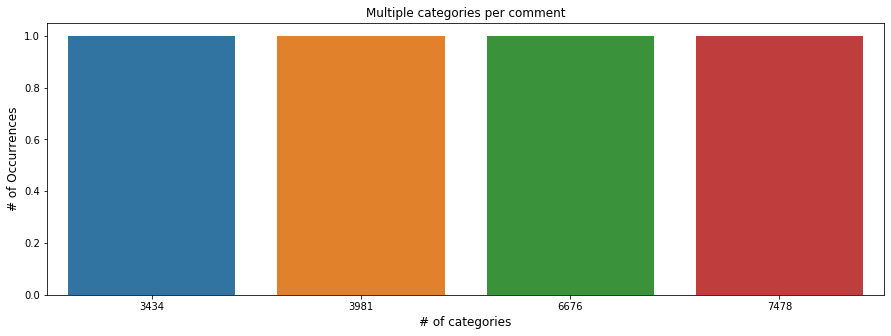

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
rowsums = movie_reviews_labels.iloc[:,:].sum(axis=0)
print(rowsums)
x=rowsums.value_counts()
#x=[movie_reviews[["cEXT"]].sum(),movie_reviews[["cNEU"]].sum(),movie_reviews[["cAGR"]].sum(),movie_reviews[["cCON"]].sum(),movie_reviews[["cOPN"]].sum()]

#plot
plt.figure(figsize=(15,5))
ax = sns.barplot(x.index, x.values)
plt.title("Multiple categories per comment")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of categories', fontsize=12)

In [0]:
def preprocess_text(sen):
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sen)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [17]:
movie_reviews.head()



,TEXT,INTROVERSION,INTUITION,THINKING,JUDGING
6100,"'Oh, looked it up. This was from the book, My...",1,1,0,0
1660,' are quite good but i don t like what they do...,1,0,1,1
2154,Doodles is all I can do :laughing: This is Elv...,1,0,0,0
8646,Its more or less based on how YOU experienced ...,1,1,0,0
1176,"'If I could have it my way in real life, chase...",1,0,0,0


In [0]:
newX = []
sentences = list(movie_reviews["TEXT"])
for sen in sentences:
    newX.append(preprocess_text(sen))

newy = movie_reviews_labels.INTROVERSION.values

In [0]:
'''
yzeros=len(newy)-np.sum(newy)
y=[] 
X=[]
for ys in range(len(newy)):
  if newy[ys]==0 or (newy[ys]==1 and np.sum(y)<yzeros):
    y.append(newy[ys])
    X.append(newX[ys])
print(len(y))
print(len(X))
'''
y=newy
X=newX

In [20]:
type(y[0])

numpy.int64

In [21]:
np.sum(y)

NameError: ignored

In [22]:
import json
import tensorflow as tf
import numpy as np
from keras.regularizers import l1

from keras.regularizers import l2
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


vocab_size = 1000
embedding_dim = 16
max_length = 120
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = int(len(X)*0.8)

sentences = X
labels = y


training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, activity_regularizer=l1(0.001))),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

num_epochs = 5

training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=1)



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 16)           16000     
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                12544     
_________________________________________________________________
dense (Dense)                (None, 24)                1560      
_________________________________________________________________
dropout (Dropout)            (None, 24)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 30,129
Trainable params: 30,129
Non-trainable params: 0
_________________________________________________________________
Train on 6940 samples, validate on 1735 samples
Epoch 1/5
6940/6940 [==============================] - 12s 2ms/sample 

In [23]:
score = model.evaluate(testing_padded, testing_labels, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

1735/1735 [==============================] - 0s 194us/sample - loss: 0.6141 - accuracy: 0.6767
Test Score: 0.6140509352732118
Test Accuracy: 0.6766571


In [24]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

KeyError: ignored

In [25]:
import keras.preprocessing.text
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences


def mean(lst): 
    return sum(lst) / len(lst) 



max_length = 120
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

predictions=[]
i=0
for j in range(50):
  i+=1
  text=np.array([movie_reviews.TEXT[i]])
  #print(text.shape)
  print(movie_reviews.TEXT[i])

  tk = keras.preprocessing.text.Tokenizer(
            
          filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
          lower=True,
          split=" ")

  tk.fit_on_texts(text)
    #pred = tk.texts_to_sequences(text)
    #print(pred)

 #model.predict(pred)

  prediction = model.predict(pad_sequences(np.asarray(tk.texts_to_sequences(text)), maxlen=max_length, padding=padding_type, truncating=trunc_type))
  predictions.append(prediction[0])
  print(prediction)
  print(movie_reviews.INTROVERSION[i], movie_reviews.INTUITION[i],movie_reviews.THINKING[i], movie_reviews.JUDGING[i])
  
    #pred = prediction[loop]
  #print(0)

'I'm finding the lack of me in these posts very alarming.Sex can be boring if it's in the same position often. For example me and my girlfriend are currently in an environment where we have to creatively use cowgirl and missionary. There isn't enough...Giving new meaning to 'Game' theory.Hello *ENTP Grin*  That's all it takes. Than we converse and they do most of the flirting while I acknowledge their presence and return their words with smooth wordplay and more cheeky grins.This + Lack of Balance and Hand Eye Coordination.Real IQ test I score 127. Internet IQ tests are funny. I score 140s or higher.  Now, like the former responses of this thread I will mention that I don't believe in the IQ test. Before you banish...You know you're an ENTP when you vanish from a site for a year and a half, return, and find people are still commenting on your posts and liking your ideas/thoughts. You know you're an ENTP when you... over think things sometimes. I go by the old Sherlock Holmes quote.  Pe

In [26]:
import keras.preprocessing.text
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences


def mean(lst): 
    return sum(lst) / len(lst) 



max_length = 120
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

#predictions=[]

for i in range(50):
  text=np.array([movie_reviews.TEXT[i]])
  #print(text.shape)
  print(movie_reviews.TEXT[i])

  tk = keras.preprocessing.text.Tokenizer(
            
          filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
          lower=True,
          split=" ")

  tk.fit_on_texts(text)
    #pred = tk.texts_to_sequences(text)
    #print(pred)

 #model.predict(pred)

  prediction = model.predict(pad_sequences(np.asarray(tk.texts_to_sequences(text)), maxlen=max_length, padding=padding_type, truncating=trunc_type))
  #predictions.append(prediction[0])
  print(prediction)
  print(predictions[0])
  
  if (prediction[0][0]>mean(predictions[0])):
    print(1)
  else:
    print(0)
  if (prediction[0][1]>mean(predictions[1])):
    print(1)
  else:
    print(0)
  if (prediction[0][2]>mean(predictions[2])):
    print(1)
  else:
    print(0)
  if (prediction[0][3]>mean(predictions[3])):
    print(1)
  else:
    print(0)

  print(movie_reviews.INTROVERSION[i], movie_reviews.INTUITION[i],movie_reviews.THINKING[i], movie_reviews.JUDGING[i])
  
    #pred = prediction[loop]
  #print(0)

' and intj moments    sportscenter not top ten plays    pranksWhat has been the most life-changing experience in your life?     On repeat for most of today.May the PerC Experience immerse you.The last thing my INFJ friend posted on his facebook before committing suicide the next day. Rest in peace~    ENFJ7. Sorry to hear of your distress. It's only natural for a relationship to not be perfection all the time in every moment of existence. Try to figure the hard times as times of growth, as...84389  84390     ...Welcome and stuff.  Game. Set. Match.Prozac, wellbrutin, at least thirty minutes of moving your legs (and I don't mean moving them while sitting in your same desk chair), weed in moderation (maybe try edibles as a healthier alternative...Basically come up with three items you've determined that each type (or whichever types you want to do) would more than likely use, given each types' cognitive functions and whatnot, when left by...All things in moderation.  Sims is indeed a vid

IndexError: ignored

In [0]:
import keras.preprocessing.text
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences


def mean(lst): 
    return sum(lst) / len(lst) 



max_length = 120
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
#text=np.array(["In light of this, introversion can be defined as an individual’s tendency to concentrate and reflect on their own inner world, giving a priority to thinking over acting, and adhering to a comfortable environment. They prefer to spend more time on their own or with a couple of people they know well. Introversion grants individuals with a set of features, which makes them completely different from the type of personality presented by extroverts. According to Cain, introverts prefer to limit their circles to a few acquaintances; however, they build extremely stable and long-lasting relationships (Cain); they tend to know people better than extroverts. Introverts become exhausted rather quickly by constant contact with other people. Introverts often prefer to work alone as opposed to with a team. They do not take action as quickly as extroverts, and tend to ponder over a problem at hand before starting to solve it. However, due of this, they often foresee consequences that escape their extrovert counterparts, thus taking more effective actions and making more efficient decisions. Due to the peculiarities of their thinking process, introverts are often misunderstood by those around them; they are often believed to be detached and unemotional, though they might be simply thinking about their interlocutor’s words. They could be experiencing a real emotional storm inside, but show little of it on the outside."])
#0111
#1100

#text=np.array(["I can't stand stupid people. Stupid people have no idea what they're doing and they're just stuck up. I'm surrounded by idiots and I cannot complain because it's my job. I have to leave this shitty please. I need to do something about before the things go bad. I already hate stupid dumb goof people and I can not tolerate anymore. I should judge them because they deserve to be. When Alice broke her engagment ring that was because she couldnot cope with the conditions.The alarming rise in the aggressive and indiscipline behaviour of modern youths like burning cars, buses, destroying public property, assaulting common men on slightest faults, eve teasing, and passing filthy comments on women raise finger at the way the society is progressing. We say we are educated, civilized and belong to great nations of the world. We say, we have high traditions, glorious culture and heritage. We feel proud for the contribution and sacrifice of our grand-parents, great grand-parents and forefathers to the nation at the cost of their personal interests and comfort and happiness. But at the same time we feel ashamed at the dangerous rise in the aggressive and violent behaviour of the present generation throughout the world though the degree of violence and aggression varies from place to place, society to society and country to country. Mahatma Gandhi and his associates who could get back the independence of India through non-violence are perhaps forgotten in this world full of violence and aggression. The remarkable increase of violence and aggression in the behaviour of the educated and uneducated, rich and poor, employers and unemployed reminds one of a world full of dangerous, chronic and infectious diseases. Aggression and violence are diseases of human mind and difficult though not impossible to cure. Most people forget the term “Non violence” under these conditions of the present society. Moreover, the cold war between big and small nations, the violent conflict between various nations on various geographical, social, economic, political and cultural issues, are on the increase in-spite of the functioning of various world peace groups. Boarder issue between various neighbouring countries has increased the aggressive and violent behaviour of people. Terrorists and Militant groups are daily engaged in mass murder of innocent citizens. Further, with the increase in atomic expulsion and atomic power groups the matter has further deteriorated and no one knows what will happen to human life next moment."])
#0010
#0110

#text=np.array(["Last week, it was my best friend’s birthday. So we all planned a nice birthday party. He asked all of us to come to his house three days before his birthday. It was supposed to be a small tea-party with a few friends and family members. As he is the eldest in the family, he asked me to come and help him with the preparations. A day before, we went to the market and brought the necessary decoration articles. We decided for a few minutes on the food and other things with my friend’s father. We also ordered for the cake from the bakery his father asked us to. We both were really excited, as my friend was turning 16 this year. I decided to go straight at his place after school to help him with the decorations. I had already kept my clothes there, so dressing up was no problem. Both Uncle and Aunty are working, so they too were very glad and relieved with me there to help their son prepare for his birthday party. One our way back home from school, we collected the cake and the eatables that we had ordered the day before. Then we hurried back home. We quickly had our lunch and headed for the drawing-room. We changed the table-cloth, cleaned the room and started with the decorations."])
#1100
#1110

#text=np.array(["I love dancing so a short speech on dance.   When I went to Bolivia my friends there knew me as “the dancer.”   I’ve learned several Latin American dances but I still missing some.   I am looking forward to continuing learning because dancing is something that gives me great joy.   The truth is that neither can explain exactly why I’m so obsessed with dancing.   What I know is that there’s nothing else that I enjoy as much as dancing.   It’s something I can do with my friends and it’s a way to meet new people.   Aside from enjoying a lot of music and dance itself, I love how every dance has a history and is an integral part of Hispanic cultures.  I want to learn more dance because I think it will help me better understand the cultures and histories of various countries. In many countries, there are national dances but I think that other non -native dances of the country are gaining more popularity?   Merengue, cambia, salsa, Durango, northern, tango – all are dances from different places in the Latin world, and many more.   Each has its special music, specific steps, and unique outfit.   Although I really like these aspects of the dances, some perhaps most important things are the stories, developments, and the ways in which the dances have affected the cultures they come from."])
#0011
#1110

#text=np.array(["Opening up to someone takes real courage which I lack. I wish I were more outgoing and extroverted because that's just how the world goes. I always feel alone in this world because I have no one to talk to, but that's fine because I do not open up to people anyway. I'm such a lonely person who pretty much never opens up to people. No one is here for me so I never tell them what's on my mind."])
#1100

#text=np.array(["I am an introvert in a sense, I feel so afraid with people and I am always nervous when asked to present something in front of everyone. I am shy and lack confidence. Always looking for someone who can help me with whatever i am going through."])

#text=np.array(["I've been through alot in my life which made me despise people. I've been backstabbed a million times and that's why I learned to never open up to anyone. Whenever you open up to someone , this someone can make use of you and your situation. It's simply my life motto, to cultivate loneliness."])

#text=np.array([movie_reviews.TEXT[0]])
print(text)
print(len(text[0]))
#print(movie_reviews.TEXT[2])

tk = keras.preprocessing.text.Tokenizer(
            
          filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
          lower=True,
          split=" ")

tk.fit_on_texts(text)
    #pred = tk.texts_to_sequences(text)
    #print(pred)

 #model.predict(pred)

prediction = model.predict(pad_sequences(np.asarray(tk.texts_to_sequences(text)), maxlen=max_length, padding=padding_type, truncating=trunc_type))

print(prediction[0][0])

if (prediction[0][0]>mean(predictions[0])):
  print(1)
else:
  print(0)
#if (prediction[0][1]>mean(predictions[1])):
#  print(1)
#else:
#  print(0)
#if (prediction[0][2]>mean(predictions[2])):
#  print(1)
#else:
#  print(0)
#if (prediction[0][3]>mean(predictions[3])):
#  print(1)
#else:
#  print(0)


print(mean(predictions[0]))
print(mean(predictions[1]))
print(mean(predictions[2]))
print(mean(predictions[3]))
print(prediction)

    #pred = prediction[loop]
    
  #print(0)

In [27]:
file1 = open 
Slangs = pd.read_csv('/content/gdrive/My Drive/nf1111/slang.txt', delimiter='\t')
Slangs

,2day,today
0,2nite,tonight
1,4u,for you
2,4ward,forward
3,a3,"anyplace, anywhere, anytime"
4,a/n,author note
...,...,...
284,yuge,huge
285,yw,you are welcome
286,ywa,you are welcome anyway
287,zomg,oh my god!


In [28]:

# Using readlines() 
file1 = open('/content/gdrive/My Drive/Names.txt', 'r') 
Lines = file1.readlines() 
  
count = 0
# Strips the newline character 
print(Lines[0])
harasser=[]
victim=[]
for line in Lines: 
  if ' V' in line:
    victim.append(line[:-3])
  elif ' P' in line:
    harasser.append(line[:-3])
'''    #print(line)
    print(line.strip()) 
    #print("Line{}: {}".format(count, line.strip())) 
'''

Decoy V



'    #print(line)\n    print(line.strip()) \n    #print("Line{}: {}".format(count, line.strip())) \n'

In [29]:
victim

['Decoy',
 'katierella1013',
 'Brandy Kennedy',
 'Decoy',
 'staceyw_14',
 'Decoy',
 'Decoy',
 'Decoy',
 'Decoy',
 'Decoy',
 'katierella1013',
 'Decoy',
 'katierella1013',
 'Decoy',
 'caffinatedboredom',
 'xocait_lynnox',
 'Decoy',
 'dont_hay_me',
 'Decoy',
 'Layla',
 'Me',
 'xocait_lynnox',
 'Decoy',
 'Decoy',
 'xlizziemariex',
 'Layla14/IN',
 'clayla13',
 'Decoy',
 'Me',
 'Decoy',
 'Decoy_name',
 'Me',
 'xocait_lynnox',
 'Me',
 'er1ca_leah_cx',
 'Maddie Ann',
 'Me',
 '14 f bama',
 'er1ca_leah_cx',
 'katy_bug007',
 'katy_bug007',
 'animal_lubbr',
 'abby_normal94',
 'yayitskc95',
 'yayitskc95',
 'l1tll3byrd',
 'robinroxxorz',
 'wickedgiggle95 ',
 'danc1njazz',
 'missie_prissie93',
 'thedoggoesw00f',
 'danc1njazz',
 'jen_is_jennah',
 'darkasnight_nolight',
 'mistygray013',
 'darke_scene_gurl_94',
 'mistygray013',
 'miss.originality123',
 'kfraley1085',
 'letpaulasleep',
 'lilredhead_1996',
 'katierella1013',
 'me0livia',
 'isabella_rawx',
 'samicelery',
 'holly_oh_golly ',
 'alyce_witha_

In [0]:
import os


def getFilesInDir(dir):
    lst = [] # Empty array
    for file in os.listdir(dir):
        lst.append(file) # will append names of files one by one.
    return lst
    
dir2 = r"/content/gdrive/My Drive/nf1111/Dataset/q42(Harassment_messages)"
# This will be the directory we will be exploring
    
files = getFilesInDir(dir2)

In [42]:
len(files)

35

In [32]:

with open (dir2 + "/"+files[4], 'r', encoding='utf-8') as fin:
  print(len(fin.read()))

257844


In [33]:
!pip install gingerit

In [34]:

from gingerit.gingerit import GingerIt
parser = GingerIt()
#line==string you wanna correct
tweet=parser.parse(line)

docs = []
docsEach=[]
for file in files:
    with open (dir2 + "/"+file, 'r', encoding='utf-8') as fin:
        for line in fin:
         for vic in victim:
           if vic in line:
            line=line[::-1]
            waste=line.find(':')  # okay so we have truncated the name of harasser and harassed here. As they weren't needed. We get then index where the chat start
            text=line[:waste+1] # We save all the chat after the : sign. Before this is the name of person sending chat
            text=text[::-1].replace('\par','').replace('\n','')
            for slang in range(len(Slangs['2day'])):
              if ' '+Slangs['2day'][slang]+' ' in text:
                text=text.replace(Slangs['2day'][slang],Slangs['today'][slang])
            #text=parser.parse(text)
            docs.append(text) # and add to an array of docs. (The name does to relate to material)
            docsEach.append(docs)
            break

print(docs[:10]) # print first 10 

[':p', '', '', '', '', '', ':/', '', '', ':48 PM']


In [35]:
docsEach[:5]

[[':p',
  '',
  '',
  '',
  '',
  '',
  ':/',
  '',
  '',
  ':48 PM',
  ':24 PM',
  ':31 PM',
  ':37 PM',
  ':58 PM',
  ':12 PM',
  ':15 PM',
  ':18 PM',
  ':29 PM',
  ':30 PM',
  ':40 PM',
  ':54 PM',
  ':54 PM',
  ':11 PM',
  ':14 PM',
  ':16 PM',
  ':16 PM',
  ':18 PM',
  ':19 PM',
  ':19 PM',
  ':20 PM',
  ':20 PM',
  ':22 PM',
  ':22 PM',
  ':24 PM',
  ':32 PM',
  ':38 PM',
  ':48 PM',
  ':54 PM',
  ':07 PM',
  ':07 PM',
  ':20 PM',
  ':37 PM',
  ':40 PM',
  ':40 PM',
  ':40 PM',
  ':44 PM',
  ':46 PM',
  ':47 PM',
  ':49 PM',
  ':49 PM',
  ':50 PM',
  ':50 PM',
  ':53 PM',
  ':53 PM',
  ':56 PM',
  ':57 PM',
  ':57 PM',
  ':18 PM',
  ':18 PM',
  ':20 PM',
  ':24 PM',
  ':25 PM',
  ':34 PM',
  ':41 PM',
  ':57 PM',
  ':57 PM',
  ':59 PM',
  ':00 PM',
  ':01 PM',
  ':02 PM',
  ':05 PM',
  '',
  ':55 AM',
  ':22 AM',
  ':57 AM',
  ':00 AM',
  ':03 AM',
  ':15 PM',
  ':18 PM',
  ':27 PM',
  ':27 PM',
  ':46 PM',
  ':46 PM',
  ':21 PM',
  ':28 PM',
  ':32 PM',
  ':32 PM',
  ':34 PM',


In [0]:
docsEachString=[]

for EachDoc in range(2):
  docs2=[]
  for i in docsEach[EachDoc]:
    s=''
    #docs2.append(i['result'][1:]+'. '.replace("\'",""))
    if (len(i)>10):
      docs2.append(i[1:]+'. '.replace("\'",""))
  docsline=s.join(docs2) 
  docsEachString.append(docsline)



In [0]:
docsEachString

In [0]:
impsentences2=['']*(int(len(docs2)/20)+1)
string=''
for i in range(len(docs2)):
 # if len(docs2[i])>10:
    impsentences2[int(i/20)]+= docs2[i].lower() 
    string+=docs2[i].lower()
string

" riverside.  fuckall lol.  not really.  hahaha ok.  i don't know if ido are not.  yeah, i guess so.  never have had.  sounds fun ok.  can't 2nite.  moms home.  yeah lol.  carrie you?.  please do.  not yet lol.  i don't know this n that.  a little.  i don't know id have to see a pic 1st.  you got 1.  where are you at neway.  ok how old.  13 is that ok.  she won't be tomorrow lol.  she works at noon.  what time.  she gets off work at like 130 am.  ok, you could come over after that.  she leaves at like noon.  yeah, if you could get here right at 1230 that would be cool.  in riverside well equally miraloma.  you can just come here lol.  do you want me to call you and tell you.  what you are named again.  hi chris im carrie.  i was kind of hoping to call you.  just to see if you are 4 real.  lot of old creepy guys here sometimes.  moms home dad.  i can't get a call, but i can call you.  no worries ill be good lol.  just want to hear you and say hi and bye.  with what.  do you have a pic o

In [0]:
for i in range (len (impsentences2)):
  print (i)
  print(impsentences2[i])

0
 riverside.  fuckall lol.  not really.  hahaha ok.  i don't know if ido are not.  yeah, i guess so.  never have had.  sounds fun ok.  can't 2nite.  moms home.  yeah lol. 
1
 carrie you?.  please do.  not yet lol.  i don't know this n that.  a little.  i don't know id have to see a pic 1st.  you got 1.  where are you at neway.  ok how old.  13 is that ok. 
2
 she won't be tomorrow lol.  she works at noon.  what time.  she gets off work at like 130 am.  ok, you could come over after that.  she leaves at like noon.  yeah, if you could get here right at 1230 that would be cool.  in riverside well equally miraloma.  you can just come here lol.  do you want me to call you and tell you.  what you are named again.  hi chris im carrie.  i was kind of hoping to call you.  just to see if you are 4 real.  lot of old creepy guys here sometimes.  moms home dad.  i can't get a call, but i can call you. 
3
 no worries ill be good lol.  just want to hear you and say hi and bye.  with what.  do you ha

In [0]:
import keras.preprocessing.text
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences


def mean(lst): 
    return sum(lst) / len(lst) 



max_length = 120
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

predictions=[]
i=0
for j in range(len(impsentences2)):
  i+=1
  text=np.array([impsentences2[i]])
  #print(text.shape)
  print(impsentences2[i])

  tk = keras.preprocessing.text.Tokenizer(
            
          filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
          lower=True,
          split=" ")

  tk.fit_on_texts(text)
    #pred = tk.texts_to_sequences(text)
    #print(pred)

 #model.predict(pred)

  prediction = model.predict(pad_sequences(np.asarray(tk.texts_to_sequences(text)), maxlen=max_length, padding=padding_type, truncating=trunc_type))
  predictions.append(prediction[0][0])
  print(prediction)
  
    #pred = prediction[loop]
  #print(0)

 carrie you?.  please do.  not yet lol.  i don't know this n that.  a little.  i don't know id have to see a pic 1st.  you got 1.  where are you at neway.  ok how old.  13 is that ok. 
[[0.99979156]]
 she won't be tomorrow lol.  she works at noon.  what time.  she gets off work at like 130 am.  ok, you could come over after that.  she leaves at like noon.  yeah, if you could get here right at 1230 that would be cool.  in riverside well equally miraloma.  you can just come here lol.  do you want me to call you and tell you.  what you are named again.  hi chris im carrie.  i was kind of hoping to call you.  just to see if you are 4 real.  lot of old creepy guys here sometimes.  moms home dad.  i can't get a call, but i can call you. 
[[0.9642032]]
 no worries ill be good lol.  just want to hear you and say hi and bye.  with what.  do you have a pic or no.  hehehe you cite.  big smiles.  you kind of look like this 1 guy i had a crush on.  nothing lol.  yeah, you look like this guy i crush

IndexError: ignored

In [0]:
np.sum(predictions)/len(predictions)

0.8959251852596507

In [0]:
import keras.preprocessing.text
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences


def mean(lst): 
    return sum(lst) / len(lst) 



max_length = 120
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
#text=np.array(["In light of this, introversion can be defined as an individual’s tendency to concentrate and reflect on their own inner world, giving a priority to thinking over acting, and adhering to a comfortable environment. They prefer to spend more time on their own or with a couple of people they know well. Introversion grants individuals with a set of features, which makes them completely different from the type of personality presented by extroverts. According to Cain, introverts prefer to limit their circles to a few acquaintances; however, they build extremely stable and long-lasting relationships (Cain); they tend to know people better than extroverts. Introverts become exhausted rather quickly by constant contact with other people. Introverts often prefer to work alone as opposed to with a team. They do not take action as quickly as extroverts, and tend to ponder over a problem at hand before starting to solve it. However, due of this, they often foresee consequences that escape their extrovert counterparts, thus taking more effective actions and making more efficient decisions. Due to the peculiarities of their thinking process, introverts are often misunderstood by those around them; they are often believed to be detached and unemotional, though they might be simply thinking about their interlocutor’s words. They could be experiencing a real emotional storm inside, but show little of it on the outside."])
#0111
#1100

#text=np.array(["I can't stand stupid people. Stupid people have no idea what they're doing and they're just stuck up. I'm surrounded by idiots and I cannot complain because it's my job. I have to leave this shitty please. I need to do something about before the things go bad. I already hate stupid dumb goof people and I can not tolerate anymore. I should judge them because they deserve to be. When Alice broke her engagment ring that was because she couldnot cope with the conditions.The alarming rise in the aggressive and indiscipline behaviour of modern youths like burning cars, buses, destroying public property, assaulting common men on slightest faults, eve teasing, and passing filthy comments on women raise finger at the way the society is progressing. We say we are educated, civilized and belong to great nations of the world. We say, we have high traditions, glorious culture and heritage. We feel proud for the contribution and sacrifice of our grand-parents, great grand-parents and forefathers to the nation at the cost of their personal interests and comfort and happiness. But at the same time we feel ashamed at the dangerous rise in the aggressive and violent behaviour of the present generation throughout the world though the degree of violence and aggression varies from place to place, society to society and country to country. Mahatma Gandhi and his associates who could get back the independence of India through non-violence are perhaps forgotten in this world full of violence and aggression. The remarkable increase of violence and aggression in the behaviour of the educated and uneducated, rich and poor, employers and unemployed reminds one of a world full of dangerous, chronic and infectious diseases. Aggression and violence are diseases of human mind and difficult though not impossible to cure. Most people forget the term “Non violence” under these conditions of the present society. Moreover, the cold war between big and small nations, the violent conflict between various nations on various geographical, social, economic, political and cultural issues, are on the increase in-spite of the functioning of various world peace groups. Boarder issue between various neighbouring countries has increased the aggressive and violent behaviour of people. Terrorists and Militant groups are daily engaged in mass murder of innocent citizens. Further, with the increase in atomic expulsion and atomic power groups the matter has further deteriorated and no one knows what will happen to human life next moment."])
#0010
#0110

#text=np.array(["Last week, it was my best friend’s birthday. So we all planned a nice birthday party. He asked all of us to come to his house three days before his birthday. It was supposed to be a small tea-party with a few friends and family members. As he is the eldest in the family, he asked me to come and help him with the preparations. A day before, we went to the market and brought the necessary decoration articles. We decided for a few minutes on the food and other things with my friend’s father. We also ordered for the cake from the bakery his father asked us to. We both were really excited, as my friend was turning 16 this year. I decided to go straight at his place after school to help him with the decorations. I had already kept my clothes there, so dressing up was no problem. Both Uncle and Aunty are working, so they too were very glad and relieved with me there to help their son prepare for his birthday party. One our way back home from school, we collected the cake and the eatables that we had ordered the day before. Then we hurried back home. We quickly had our lunch and headed for the drawing-room. We changed the table-cloth, cleaned the room and started with the decorations."])
#1100
#1110

#text=np.array(["I love dancing so a short speech on dance.   When I went to Bolivia my friends there knew me as “the dancer.”   I’ve learned several Latin American dances but I still missing some.   I am looking forward to continuing learning because dancing is something that gives me great joy.   The truth is that neither can explain exactly why I’m so obsessed with dancing.   What I know is that there’s nothing else that I enjoy as much as dancing.   It’s something I can do with my friends and it’s a way to meet new people.   Aside from enjoying a lot of music and dance itself, I love how every dance has a history and is an integral part of Hispanic cultures.  I want to learn more dance because I think it will help me better understand the cultures and histories of various countries. In many countries, there are national dances but I think that other non -native dances of the country are gaining more popularity?   Merengue, cambia, salsa, Durango, northern, tango – all are dances from different places in the Latin world, and many more.   Each has its special music, specific steps, and unique outfit.   Although I really like these aspects of the dances, some perhaps most important things are the stories, developments, and the ways in which the dances have affected the cultures they come from."])
#0011
#1110

#text=np.array(["Opening up to someone takes real courage which I lack. I wish I were more outgoing and extroverted because that's just how the world goes. I always feel alone in this world because I have no one to talk to, but that's fine because I do not open up to people anyway. I'm such a lonely person who pretty much never opens up to people. No one is here for me so I never tell them what's on my mind."])
#1100

#text=np.array(["I am an introvert in a sense, I feel so afraid with people and I am always nervous when asked to present something in front of everyone. I am shy and lack confidence. Always looking for someone who can help me with whatever i am going through."])

#text=np.array(["I've been through alot in my life which made me despise people. I've been backstabbed a million times and that's why I learned to never open up to anyone. Whenever you open up to someone , this someone can make use of you and your situation. It's simply my life motto, to cultivate loneliness."])
text=string
#text=np.array([movie_reviews.TEXT[0]])
print(text)
print(len(text[0]))
#print(movie_reviews.TEXT[2])

tk = keras.preprocessing.text.Tokenizer(
            
          filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
          lower=True,
          split=" ")

tk.fit_on_texts(text)
    #pred = tk.texts_to_sequences(text)
    #print(pred)

 #model.predict(pred)

print(prediction[0][0])
prediction = model.predict(pad_sequences(np.asarray(tk.texts_to_sequences(text)), maxlen=max_length, padding=padding_type, truncating=trunc_type))
if (prediction[0][0]>mean(predictions[0])):
  print(1)
else:
  print(0)
if (prediction[0][1]>mean(predictions[1])):
  print(1)
else:
  print(0)
if (prediction[0][2]>mean(predictions[2])):
  print(1)
else:
  print(0)
if (prediction[0][3]>mean(predictions[3])):
  print(1)
else:
  print(0)


print(mean(predictions[0]))
print(mean(predictions[1]))
print(mean(predictions[2]))
print(mean(predictions[3]))
print(prediction)

    #pred = prediction[loop]
    
  #print(0)

In [0]:
import os

dirr = r"/content/gdrive/My Drive/Traits"
# This will be the directory we will be exploring
    
files = getFilesInDir(dirr)

for loop in range(len(files)):
  Aggression = pd.read_csv(dirr + "/"+files[loop], sep=',', engine='python')

  Aggression.isnull().values.any()

  Aggression.shape

  count=[0,0]

  ones=0
  zeros=0
  for i in range(len(Aggression)):
    if Aggression['result'][i]=='y':
      if ones<1000:
        Aggression['result'][i]=1
        count[0]=count[0]+1
        ones=ones+1
      else:
        Aggression=Aggression.drop(i)
    else:
      if zeros<1000:
        Aggression['result'][i]=0
        count[1]=count[1]+1
        zeros=zeros+1
      else:
        Aggression=Aggression.drop(i)
   
  #print(ones)
  #print(zeros)
  df=Aggression


  import re

  reviews = []
  sentences = list(df['TEXT'])
  for sen in sentences:
      reviews.append(preprocess_text(sen))
  y = Aggression[['result']]
  y.head()


  for i in range(10):
    print(reviews[i])


  BertTokenizer = bert.bert_tokenization.FullTokenizer
  bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1", trainable=False)
  vocabulary_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
  to_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
  tokenizer = BertTokenizer(vocabulary_file, to_lower_case)

  tokenized_reviews = [tokenize_reviews(review) for review in reviews]

  sorted_reviews_label=reviews
  print(len(tokenized_reviews))
  #reviews_with_len = [[review,y['result'][i], len(review)]
  #                for i, review in enumerate(tokenized_reviews)]
  #reviews_with_len = [[review,y['cEXT'][i], len(review)]

  import random

  #random.shuffle(reviews_with_len)

  #reviews_with_len.sort(key=lambda x: x[2])
  #sorted_reviews_labels = [(review_lab[0], review_lab[1]) for review_lab in reviews_with_len]
  #sorted_reviews_labels = [(review_lab[0], review_lab[1],review_lab[2], review_lab[3],review_lab[4], review_lab[5]) for review_lab in reviews_with_len]
  processed_dataset = tf.data.Dataset.from_generator(lambda: sorted_reviews_labels, output_types=(tf.int32, tf.int32))
  #processed_dataset = tf.data.Dataset.from_generator(lambda: sorted_reviews_labels, output_types=(tf.int32, tf.int32,tf.int32, tf.int32,tf.int32, tf.int32))

  BATCH_SIZE = 32
  batched_dataset = processed_dataset.padded_batch(BATCH_SIZE, padded_shapes=((None, ), ()))
  batched_dataset

  next(iter(batched_dataset))

  import math
  TOTAL_BATCHES = math.ceil(len(sorted_reviews_labels) / BATCH_SIZE)
  TEST_BATCHES = TOTAL_BATCHES // 10
  batched_dataset.shuffle(TOTAL_BATCHES)
  test_data = batched_dataset.take(TEST_BATCHES)
  train_data = batched_dataset.skip(TEST_BATCHES)




  VOCAB_LENGTH = len(tokenizer.vocab)
  EMB_DIM = 200
  CNN_FILTERS = 100
  DNN_UNITS = 256
  OUTPUT_CLASSES = 2


  DROPOUT_RATE = 0.4

  NB_EPOCHS = 5
  
  text_model.append( TEXT_MODEL(vocabulary_size=VOCAB_LENGTH,
                          embedding_dimensions=EMB_DIM,
                          cnn_filters=CNN_FILTERS,
                          dnn_units=DNN_UNITS,
                          model_output_classes=OUTPUT_CLASSES,
                          dropout_rate=DROPOUT_RATE)
                    )



  if OUTPUT_CLASSES == 2:
      text_model[loop].compile(loss="binary_crossentropy",
                        optimizer="adam",
                        metrics=["accuracy"])
  else:
    text_model[loop].compile(loss="sparse_categorical_crossentropy",
                        optimizer="adam",
                        metrics=["sparse_categorical_accuracy"])
    
    #text_model.fit(train_data, epochs=NB_EPOCHS)

  text_model[loop].fit(train_data,
            epochs=20, validation_data=test_data, verbose=1)


In [0]:
# install ktrain
!pip3 install ktrain

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf

TensorFlow 2.x selected.


In [0]:
# import ktrain

import tensorflow as tf
import ktrain
from ktrain import text

using Keras version: 2.2.4-tf


In [0]:
ktrain.__version__

'0.9.4'

In [0]:

# download IMDb movie review dataset
import tensorflow as tf
dataset = tf.keras.utils.get_file(
    fname="aclImdb.tar.gz", 
    origin="http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz", 
    extract=True,
)

84131840/84125825 [==============================] - 4s 0us/step


In [0]:
# set path to dataset
import os.path
#dataset = '/root/.keras/datasets/aclImdb'
IMDB_DATADIR = os.path.join(os.path.dirname(dataset), 'aclImdb')
print(IMDB_DATADIR)

/root/.keras/datasets/aclImdb


In [0]:
ls '/root/.keras/datasets/aclImdb/test/neg/4247_4.txt'

/root/.keras/datasets/aclImdb/test/neg/4247_4.txt


In [0]:
preproc

In [0]:
(x_train, y_train), (x_test, y_test), preproc = text.texts_from_folder(IMDB_DATADIR, 
                                                                       maxlen=500, 
                                                                       preprocess_mode='bert',
                                                                       train_test_names=['train', 
                                                                                         'test'],
                                                                       classes=['pos', 'neg'])

detected encoding: utf-8
downloading pretrained BERT model (uncased_L-12_H-768_A-12.zip)...
[██████████████████████████████████████████████████]
extracting pretrained BERT model...
done.

cleanup downloaded zip...
done.

preprocessing train...
language: en


preprocessing test...
language: en


In [0]:
model = text.text_classifier('bert', (x_train, y_train), preproc=preproc)
learner = ktrain.get_learner(model,train_data=(x_train, y_train), val_data=(x_test, y_test), batch_size=6)

Is Multi-Label? False
maxlen is 500
done.


In [0]:
learner.fit_onecycle(2e-5, 1)



begin training using onecycle policy with max lr of 2e-05...
Train on 25000 samples, validate on 25000 samples
  822/25000 [..............................] - ETA: 52:49 - loss: 0.6475 - accuracy: 0.6176

KeyboardInterrupt: ignored

In [0]:
import os

dirr = r"/content/gdrive/My Drive/Traits"
# This will be the directory we will be exploring
    
files = getFilesInDir(dirr)
len(files)

5

In [0]:
len(text_model)

0

In [0]:
import keras.preprocessing.text
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences


def mean(lst): 
    return sum(lst) / len(lst) 



max_length = 120
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

prediction=[[],[],[],[],[],[]]
#text = np.array(['sitting here just writing stuff down on paper. thinking about going out tonight. Iï¿½m pretty happy because the navy paid me some more money. so there is money to go out with. Iï¿½m doing this on paper hoping it's a little easier than just typing. time goes slow when you are waiting on it. that girl is really cute. I can not concentrate on one thing for that long of a time. there are people here talking which takes my attention. the football game tomorrow. Iï¿½m not going. every body seems to be gung-ho about going. I don't see the big deal. watch it on tv who is lance corporal ruther. being late for pt would suck because they make you write about that stuff. thoughts are a weird thing everything you look at will bring on a thought the books, people everything they talk about will make you think a certain thing and it's not like you can ignore them when there in the same room. there's too much time for me to make up today. I can't do it. I wonder what they'll do. probably not much Iï¿½ll have about three quarters of I so it shouldn't be a big deal. it's good that we have it but it should be open alot later than just 9 o'clock. extra study. the ROTC unit is good that way I guess I wonder how late I have to stay there today. it doesn't really matter I guess but I want to go out tonight this is my one night to go out and get drunk so I plan on doing it not real bad but some. people are trying to figure out there total hours. I need to but I doubt it'll help it's funny how people use there study hours. mostly trying to figure out little things to do. everything but study. I think that's time I hope this is close to what the assignment was.'])
for loop in range(5):
  for i in range(50):
    text=np.array([reviews[i]])
    #print(text.shape)
    #print(reviews[i])

    tk = keras.preprocessing.text.Tokenizer(
            
            filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
            lower=True,
            split=" ")

    tk.fit_on_texts(text)
    #pred = tk.texts_to_sequences(text)
    #print(pred)

    #model.predict(pred)

    pred = prediction[loop]
    pred.append( text_model[loop].predict(pad_sequences(np.asarray(tk.texts_to_sequences(text)), maxlen=max_length, padding=padding_type, truncating=trunc_type)))
    #print(prediction)

MEANEXT=mean(prediction[0])
MEANNEU=mean(prediction[1])
MEANAGR=mean(prediction[2])
MEANCON=mean(prediction[3])
MEANOPN=mean(prediction[4])
for i in range(50):
    if prediction[0][i]>mean(prediction[0]):
      print (1 )
    else:
      print(0)
    if prediction[1][i]>mean(prediction[1]):
      print (1 )
    else:
      print(0)
    if prediction[2][i]>mean(prediction[2]):
      print (1 )
    else:
      print(0)
    if prediction[3][i]>mean(prediction[3]):
      print (1 )
    else:
      print(0)
    if prediction[4][i]>mean(prediction[4]):
      print (1 )
    else:
      print(0)
    
    print(" ")
    # 0.4

IndexError: ignored

In [0]:
victim[0]

'Decoy'

In [0]:
dir2 = r"/content/gdrive/My Drive/nf1111/Dataset/q42(Harassment_messages)"
    
files = getFilesInDir(dir2)
    
    
AllChats = []
eachchat = 0
for file in files:
    with open (dir2 + "/"+file, 'r', encoding='utf-8') as fin:
        #print(victim[eachchat])
        texts=[]
        for line in fin:
          for victims in victim:
            if victims in line:
              waste=line.find('PM):')  # okay so we have truncated the name of harasser and harassed here. As they weren't needed. We get then index where the chat start
              text=line[waste+4:] # We save all the chat after the : sign. Before this is the name of person sending chat
              text=text.replace('\\par\n',' ')
              texts.append(text) # and add to an array of docs. (The name does to relate to material)
              break;
        #print(texts)
        print(file)
        
    AllChats.append(texts)
    eachchat+=1
#docs=stemming(docs)
print(AllChats[2]) # print first 10 
        
    

10.rtf
11.rtf
12.rtf
13.rtf
14.rtf
15.rtf
2.rtf
3.rtf
4.rtf
5.rtf
6.rtf
7.rtf
8.rtf
9.rtf
67.rtf
68.rtf
72.rtf
69.rtf
71.rtf
74.rtf
73.rtf
65.rtf
70.rtf
66.rtf
75.rtf
76.rtf
77.rtf
78.rtf
79.rtf
80.rtf
81.rtf
83.rtf
84.rtf
82.rtf
85.rtf
[' lolz thx. how r u? ', " kewl. i'm 13 f utah ", ' how old r u? ', ' lolz.... u funny cute ', ' im kinda having fun i guess. just hanging out waiting for my dinner to b ready :)  ', ' n u? what u up to? ', ' lolz kewl i guess lolz ', ' i like chatting too :) ', ' what u been doing today? did u gotta work or something? ', ' working at school :) ', " my name's katie btw - whats urs? ", " hi paul. n no, i don't got a bf at the mo :) ", ' what about u? ', ' a gf i mean lol ', ' kewl, thats fun ', " sure, n i'm a girl n so do i lol ", ' so do you look like the cartoon pic? ', ' or do you got a real pic i can see??? ;) ', ' oh, u still at work? ', ' oh that kinda sux. what do you do? anything fun? ', ' yeah :"> ', ' lol ', ' its fun ', ' well i had a bf this

In [0]:
print(AllChats[15][4]) 

 cuz i was installing something 


In [0]:
import keras.preprocessing.text
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences


def mean(lst): 
    return sum(lst) / len(lst) 



max_length = 120
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

prediction=[[],[],[],[],[],[]]
#text = np.array(['sitting here just writing stuff down on paper. thinking about going out tonight. Iï¿½m pretty happy because the navy paid me some more money. so there is money to go out with. Iï¿½m doing this on paper hoping it's a little easier than just typing. time goes slow when you are waiting on it. that girl is really cute. I can not concentrate on one thing for that long of a time. there are people here talking which takes my attention. the football game tomorrow. Iï¿½m not going. every body seems to be gung-ho about going. I don't see the big deal. watch it on tv who is lance corporal ruther. being late for pt would suck because they make you write about that stuff. thoughts are a weird thing everything you look at will bring on a thought the books, people everything they talk about will make you think a certain thing and it's not like you can ignore them when there in the same room. there's too much time for me to make up today. I can't do it. I wonder what they'll do. probably not much Iï¿½ll have about three quarters of I so it shouldn't be a big deal. it's good that we have it but it should be open alot later than just 9 o'clock. extra study. the ROTC unit is good that way I guess I wonder how late I have to stay there today. it doesn't really matter I guess but I want to go out tonight this is my one night to go out and get drunk so I plan on doing it not real bad but some. people are trying to figure out there total hours. I need to but I doubt it'll help it's funny how people use there study hours. mostly trying to figure out little things to do. everything but study. I think that's time I hope this is close to what the assignment was.'])
for loop in range(5):
  for i in range(50):
    text=np.array([AllChats[15][i]])
    #print(text.shape)
    #print(reviews[i])

    tk = keras.preprocessing.text.Tokenizer(
            
            filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
            lower=True,
            split=" ")

    tk.fit_on_texts(text)
    #pred = tk.texts_to_sequences(text)
    #print(pred)

    #model.predict(pred)

    pred = prediction[loop]
    pred.append( text_model[loop].predict(pad_sequences(np.asarray(tk.texts_to_sequences(text)), maxlen=max_length, padding=padding_type, truncating=trunc_type)))
    #print(prediction)

print(mean(prediction[0]))
print(mean(prediction[1]))
print(mean(prediction[2]))
print(mean(prediction[3]))
print(mean(prediction[4]))
'''
if mean(prediction[0])>MEANEXT:
      print (1 )
else:
      print(0)
if mean(prediction[1])>MEANNEU:
      print (1 )
else:
      print(0)
if mean(prediction[2])>MEANAGR:
      print (1 )
else:
      print(0)
if mean(prediction[3])>MEANCON:
      print (1 )
else:
      print(0)
if mean(prediction[4])>MEANOPN:
      print (1 )
else:
      print(0)
'''  



IndexError: ignored

In [0]:
len(prediction[5])

0

In [0]:
Aggression = pd.read_csv("/content/gdrive/My Drive/_CON.csv", sep=',', engine='python')

Aggression.isnull().values.any()

Aggression.shape

count=[0,0]
for i in range(len(Aggression)):
  if Aggression['result'][i]=='y':
    Aggression['result'][i]=1
    count[0]=count[0]+1
  else:
    Aggression['result'][i]=0
    count[1]=count[1]+1

FileNotFoundError: ignored

In [0]:
df=Aggression

In [0]:
import re

reviews = []
sentences = list(df['TEXT'])
for sen in sentences:
    reviews.append(preprocess_text(sen))

In [0]:
y = Aggression[['result']]
y.head()

In [0]:
for i in range(10):
  print(reviews[i])

In [0]:
BertTokenizer = bert.bert_tokenization.FullTokenizer
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1", trainable=False)
vocabulary_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
to_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = BertTokenizer(vocabulary_file, to_lower_case)

In [0]:
tokenizer.tokenize("don't be so judgmental")

In [0]:
tokenized_reviews = [tokenize_reviews(review) for review in reviews]

In [0]:
reviews_with_len = [[review,y['result'][i], len(review)]
#reviews_with_len = [[review,y['cEXT'][i], len(review)]
                 for i, review in enumerate(tokenized_reviews)]

In [0]:
import random

random.shuffle(reviews_with_len)

In [0]:
print(reviews[:10])

['Well right now just woke up from mid day nap It sort of weird but ever since moved to Texas have had problems concentrating on things remember starting my homework in th grade as soon as the clock struck and not stopping until it was done Of course it was easier but still did it But when moved here the homework got little more challenging and there was lot more busy work and so decided not to spend hours doing it and just getting by But the thing was that always paid attention in class and just plain out knew the stuff and now that look back if had really worked hard and stayed on track the last two years without getting lazy would have been genius but hey that all good It too late to correct the past but don really know how to stay focused the future The one thing know is that when people say that c they live on campus they can concentrate it b For me it would be easier there but alas m living at home under the watchful eye of my parents and little nagging sister that just nags and 

In [0]:
reviews_with_len.sort(key=lambda x: x[2])
sorted_reviews_labels = [(review_lab[0], review_lab[1]) for review_lab in reviews_with_len]
#sorted_reviews_labels = [(review_lab[0], review_lab[1],review_lab[2], review_lab[3],review_lab[4], review_lab[5]) for review_lab in reviews_with_len]
processed_dataset = tf.data.Dataset.from_generator(lambda: sorted_reviews_labels, output_types=(tf.int32, tf.int32))
#processed_dataset = tf.data.Dataset.from_generator(lambda: sorted_reviews_labels, output_types=(tf.int32, tf.int32,tf.int32, tf.int32,tf.int32, tf.int32))

BATCH_SIZE = 32
batched_dataset = processed_dataset.padded_batch(BATCH_SIZE, padded_shapes=((None, ), ()))
batched_dataset

<PaddedBatchDataset shapes: ((None, None), (None,)), types: (tf.int32, tf.int32)>

In [0]:
next(iter(batched_dataset))

(<tf.Tensor: shape=(32, 197), dtype=int32, numpy=
 array([[10303,  2054,  2064, ...,     0,     0,     0],
        [ 2023,  3105,  2003, ...,     0,     0,     0],
        [ 1045,  2215,  2000, ...,     0,     0,     0],
        ...,
        [ 1996,  6057,  2518, ...,     0,     0,     0],
        [ 2823,  2123,  3305, ...,     0,     0,     0],
        [ 2174,  2514,  2071, ...,  1999,  2026,  3752]], dtype=int32)>,
 <tf.Tensor: shape=(32,), dtype=int32, numpy=
 array([1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0,
        0, 0, 1, 1, 1, 0, 1, 0, 1, 1], dtype=int32)>)

In [0]:
import math
TOTAL_BATCHES = math.ceil(len(sorted_reviews_labels) / BATCH_SIZE)
TEST_BATCHES = TOTAL_BATCHES // 10
batched_dataset.shuffle(TOTAL_BATCHES)
test_data = batched_dataset.take(TEST_BATCHES)
train_data = batched_dataset.skip(TEST_BATCHES)

In [0]:
from keras import regularizers

class TEXT_MODEL(tf.keras.Model):
    
    def __init__(self,
                 vocabulary_size,
                 embedding_dimensions=128,
                 cnn_filters=50,
                 dnn_units=512,
                 model_output_classes=2,
                 dropout_rate=0.1,
                 training=False,
                 name="text_model"):
        super(TEXT_MODEL, self).__init__(name=name)
        
        self.embedding = layers.Embedding(vocabulary_size,
                                          embedding_dimensions)
        self.cnn_layer1 = layers.Conv1D(filters=cnn_filters,
                                        kernel_size=2,
                                        padding="valid",
                                        activation="relu")
        self.cnn_layer2 = layers.Conv1D(filters=cnn_filters,
                                        kernel_size=3,
                                        padding="valid",
                                        activation="relu")
        self.cnn_layer3 = layers.Conv1D(filters=cnn_filters,
                                        kernel_size=4,
                                        padding="valid",
                                        activation="relu")
        self.pool = layers.GlobalMaxPool1D()
        
        self.dense_1 = layers.Dense(units=dnn_units, activation="relu")
        self.dropout = layers.Dropout(rate=dropout_rate)
        if model_output_classes == 2:
            self.last_dense = layers.Dense(units=1,
                                           activation="sigmoid",kernel_regularizer=regularizers.l2(0.01),activity_regularizer=regularizers.l1(0.01))
        else:
            self.last_dense = layers.Dense(units=model_output_classes,
                                           activation="softmax",kernel_regularizer=regularizers.l2(0.01),activity_regularizer=regularizers.l1(0.01))
    
    def call(self, inputs, training):
        l = self.embedding(inputs)
        l_1 = self.cnn_layer1(l) 
        l_1 = self.pool(l_1) 
        l_2 = self.cnn_layer2(l) 
        l_2 = self.pool(l_2)
        l_3 = self.cnn_layer3(l)
        l_3 = self.pool(l_3) 
        
        concatenated = tf.concat([l_1, l_2, l_3], axis=-1) # (batch_size, 3 * cnn_filters)
        concatenated = self.dense_1(concatenated)
        concatenated = self.dropout(concatenated, training)
        model_output = self.last_dense(concatenated)
        
        return model_output

In [0]:
VOCAB_LENGTH = len(tokenizer.vocab)
EMB_DIM = 200
CNN_FILTERS = 100
DNN_UNITS = 256
OUTPUT_CLASSES = 2


DROPOUT_RATE = 0.2

NB_EPOCHS = 5

In [0]:
text_model = TEXT_MODEL(vocabulary_size=VOCAB_LENGTH,
                        embedding_dimensions=EMB_DIM,
                        cnn_filters=CNN_FILTERS,
                        dnn_units=DNN_UNITS,
                        model_output_classes=OUTPUT_CLASSES,
                        dropout_rate=DROPOUT_RATE)

In [0]:

if OUTPUT_CLASSES == 2:
    text_model.compile(loss="binary_crossentropy",
                       optimizer="adam",
                       metrics=["accuracy"])
else:
  text_model.compile(loss="sparse_categorical_crossentropy",
                       optimizer="adam",
                       metrics=["sparse_categorical_accuracy"])

In [0]:
#text_model.fit(train_data, epochs=NB_EPOCHS)

text_model.fit(train_data,
          epochs=20, validation_data=test_data, verbose=1)

Epoch 1/20
71/71 [==============================] - 7s 97ms/step - loss: 0.7190 - accuracy: 0.4909 - val_loss: 0.7025 - val_accuracy: 0.5312
Epoch 2/20
71/71 [==============================] - 6s 85ms/step - loss: 0.6789 - accuracy: 0.5947 - val_loss: 0.6918 - val_accuracy: 0.5670
Epoch 3/20
71/71 [==============================] - 6s 84ms/step - loss: 0.5224 - accuracy: 0.8217 - val_loss: 0.8101 - val_accuracy: 0.4911
Epoch 4/20
71/71 [==============================] - 6s 87ms/step - loss: 0.1729 - accuracy: 0.9795 - val_loss: 0.8146 - val_accuracy: 0.5402
Epoch 5/20
71/71 [==============================] - 6s 86ms/step - loss: 0.0403 - accuracy: 1.0000 - val_loss: 0.9690 - val_accuracy: 0.5580
Epoch 6/20
71/71 [==============================] - 6s 85ms/step - loss: 0.0298 - accuracy: 1.0000 - val_loss: 1.1947 - val_accuracy: 0.5223
Epoch 7/20
71/71 [==============================] - 6s 85ms/step - loss: 0.0275 - accuracy: 1.0000 - val_loss: 1.2167 - val_accuracy: 0.5223
Epoch 8/20
71

In [0]:
import keras.preprocessing.text
import numpy as np

from tensorflow.keras.preprocessing.sequence import pad_sequences



max_length = 120
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"


#text = np.array(['sitting here just writing stuff down on paper. thinking about going out tonight. Iï¿½m pretty happy because the navy paid me some more money. so there is money to go out with. Iï¿½m doing this on paper hoping it's a little easier than just typing. time goes slow when you are waiting on it. that girl is really cute. I can not concentrate on one thing for that long of a time. there are people here talking which takes my attention. the football game tomorrow. Iï¿½m not going. every body seems to be gung-ho about going. I don't see the big deal. watch it on tv who is lance corporal ruther. being late for pt would suck because they make you write about that stuff. thoughts are a weird thing everything you look at will bring on a thought the books, people everything they talk about will make you think a certain thing and it's not like you can ignore them when there in the same room. there's too much time for me to make up today. I can't do it. I wonder what they'll do. probably not much Iï¿½ll have about three quarters of I so it shouldn't be a big deal. it's good that we have it but it should be open alot later than just 9 o'clock. extra study. the ROTC unit is good that way I guess I wonder how late I have to stay there today. it doesn't really matter I guess but I want to go out tonight this is my one night to go out and get drunk so I plan on doing it not real bad but some. people are trying to figure out there total hours. I need to but I doubt it'll help it's funny how people use there study hours. mostly trying to figure out little things to do. everything but study. I think that's time I hope this is close to what the assignment was.'])
for i in range(50):
  text=np.array([reviews[i]])
  #print(text.shape)
  print(reviews[i])

  tk = keras.preprocessing.text.Tokenizer(
          
          filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
          lower=True,
          split=" ")

  tk.fit_on_texts(text)
  #pred = tk.texts_to_sequences(text)
  #print(pred)

  #model.predict(pred)

  prediction = text_model.predict(pad_sequences(np.asarray(tk.texts_to_sequences(text)), maxlen=max_length, padding=padding_type, truncating=trunc_type))
  print(prediction)

  # 0.4

Well right now just woke up from mid day nap It sort of weird but ever since moved to Texas have had problems concentrating on things remember starting my homework in th grade as soon as the clock struck and not stopping until it was done Of course it was easier but still did it But when moved here the homework got little more challenging and there was lot more busy work and so decided not to spend hours doing it and just getting by But the thing was that always paid attention in class and just plain out knew the stuff and now that look back if had really worked hard and stayed on track the last two years without getting lazy would have been genius but hey that all good It too late to correct the past but don really know how to stay focused the future The one thing know is that when people say that c they live on campus they can concentrate it b For me it would be easier there but alas m living at home under the watchful eye of my parents and little nagging sister that just nags and na